In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
from rasterio import features
from affine import Affine
import matplotlib.pyplot as plt 
%matplotlib inline
import xarray as xr
# import rioxarray
import regionmask
import glob
from shapely.geometry import Polygon, MultiPolygon, shape
import src.clipping_functions as cf
# from src.clipping_functions import create_mask_from_geom, open_relative_humidity_file, extract_noon_array, shift_longitude_to_negative_coords

In [2]:
def mask_RH_w_wildfire_shp(lat, long, nearest_coord):
    if (long, lat) == nearest_coord:
        return 1
    else:
        return 0
    
def nearest_latlong(long, lat, xrArray):
    nearest_lat = xrArray.sel(latitude = lat, method='nearest')
    nearest_long = xrArray.sel(longitude = long, method='nearest')
    return nearest_long.longitude, nearest_lat.latitude

In [ ]:
 
weather_crs = {'init': 'epsg:4326'}
base_path_to_weather_data = "/data/raw_data/era5/unpacked/R/417331.R.2678.e5.oper.an.pl.128_157_r.ll025sc."  #*.nc"
nuts_regions = gpd.read_file( '/data/raw_data/nuts_regions_highres//NUTS_RG_01M_2016_3857.geojson')
nuts_regions_changed_crs = nuts_regions.to_crs(weather_crs)
france_region = nuts_regions_changed_crs.query("NUTS_ID == 'FRJ' and NUTS_ID == 'FRK' and NUTS_ID == 'FRC'and NUTS_ID == 'FRD' ")
var_region = nuts_regions_changed_crs.query("NUTS_ID == 'FRL'")
shapes = [(shape, n) for n, shape in enumerate(var_region.geometry)]

nuts_regions_crs = nuts_regions.crs
bb = var_region.iloc[0].geometry.bounds
path_to_ground_truth_shp_files = '/data/raw_data/wildfires-ground-truth/france/vars/*.shp'
all_ground_truth_path_list = glob.glob(path_to_ground_truth_shp_files)


In [ ]:

new_arrary_for_hist = None 
wildfire_humidities_array = []
no_wildfire_humidities_array = []
for file in all_ground_truth_path_list:
    year = int(file[-14:-10])
    if year > 2002 :
        wildfire_groud_truth = gpd.read_file(file)
        wildfire_ground_truth_changed_crs = wildfire_groud_truth.to_crs(weather_crs)
        for index, row in wildfire_ground_truth_changed_crs.iterrows(): 
            date_of_wildfire_str = row.DATE_ECLOS.replace("-", "")
            RH_path_for_date = base_path_to_weather_data + date_of_wildfire_str +"*.nc"
            RH_file_for_date = glob.glob(RH_path_for_date)
            open_RH_data = xr.open_dataset(RH_file_for_date[0])
            
            noon = open_RH_data.time[12]
            noon_RH_data = open_RH_data.where(open_RH_data.time == noon, drop=True)
            noon_RH_data = noon_RH_data.assign_coords({'longitude': (((noon_RH_data.longitude +180)%360) -180)})
            
            masks = cf.create_mask_from_geom(geom=var_region.geometry.iloc[0], xrArray=noon_RH_data)
            noon_RH_data['mask'] = masks
            noon_RH_bound = noon_RH_data.where(noon_RH_data.mask == 0, drop=True)

            WF_shp_bounds = row.geometry.bounds
            nearest_min_long, nearest_min_lat = nearest_latlong(WF_shp_bounds[0], WF_shp_bounds[1], noon_RH_bound)
            nearest_max_long, nearest_max_lat = nearest_latlong(WF_shp_bounds[2], WF_shp_bounds[3], noon_RH_bound)
            
            nearest_min_coord = (nearest_min_long, nearest_min_lat)
            nearest_max_coord = (nearest_max_long, nearest_max_lat)
            if nearest_min_coord == nearest_max_coord:
                nearest_coord = nearest_min_coord
                noon_RH_copy = noon_RH_bound.copy()
                noon_RH_clipped = noon_RH_copy.where(noon_RH_copy.longitude == nearest_coord[0].values, 1).where(noon_RH_copy.latitude == nearest_coord[1].values, 1)
                noon_RH_bound['WF_mask'] = noon_RH_clipped.mask
                no_wildfire_xarray = noon_RH_bound.where(noon_RH_bound.WF_mask == 1, drop=True)
                wild_fire_xarray = noon_RH_bound.where(noon_RH_bound.WF_mask == 0, drop=True)   
                wildfire_humidities_array = np.hstack((wildfire_humidities_array, np.asarray(wild_fire_xarray.R.to_dict()['data']).flatten()))
                no_wildfire_humidities_array = np.hstack((no_wildfire_humidities_array, np.asarray(no_wildfire_xarray.R.to_dict()['data']).flatten()))
                

hist, bins = np.histogram(wildfire_humidities_array, bins=[0,10,20,30,40,50,60,70,80,90,100])
plt.xlabel('Relative humidity %')
plt.ylabel('Number of pixels')
plt.hist(wildfire_humidities_array, bins=bins, color='blue', alpha=1)
plt.hist(no_wildfire_humidities_array, bins=bins, color='red', alpha=0.2)

(array([0.        , 0.        , 0.00047548, 0.00362556, 0.01396731,
        0.03031204, 0.04196137, 0.03869242, 0.02508172, 0.01634473,
        0.01135215, 0.00576523, 0.00427935, 0.0028529 , 0.00213967,
        0.0010104 , 0.00077266, 0.0008321 , 0.00053492]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

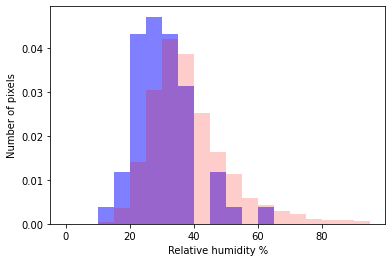

In [101]:
bins = [i for i in range(0,100,5)]
plt.xlabel('Relative humidity %')
plt.ylabel('Number of pixels')
plt.hist(wildfire_humidities_array, bins=bins, color='blue', alpha=0.5, density=True)
plt.hist(no_wildfire_humidities_array, bins=bins, color='red', alpha=0.2, density=True)

**References**

Check whether a point is inside a Polygon - https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python

In [ ]:
#         fig, ax = plt.subplots(figsize = (20,16)) 
#         plt.title("NUTS region FRL05 (Var) and ground truth of all wildfires in {}".format(year))
#         var_region.plot(ax=ax)
#         france_region.plot(ax=ax)
#         wildfire_groud_truth = gpd.read_file(file)
#         wildfire_ground_truth_changed_crs = wildfire_groud_truth.to_crs(weather_crs)
#         wildfire_ground_truth_changed_crs.plot(color='Red',edgecolor='k',linewidth = 2,ax=ax)
            

In [ ]:
# rasterise and mask xarray

In [74]:
np.ndarray(wild_fire_xarray.R.to_dict()['data'])

TypeError: 'list' object cannot be interpreted as an integer

In [75]:
wild_fire_xarray.R.to_dict()['data']

[[[[36.53831481933594]]]]

In [86]:
np.asarray(no_wildfire_xarray.R.to_dict()['data'][0][0])

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 52.85472107, 48.36253357,
        48.66331482,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan, 43.48362732, 49.02659607, 45.90550232,
        48.77268982, 69.34300232,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan, 37.06175232, 36.81956482, 44.70628357, 47.26878357,
        50.26878357,         nan,         nan,         nan],
       [        nan,         nan, 30.03441048, 22.87816048,         nan,
                nan, 30.90159798, 33.23753357, 42.28440857, 46.80003357,
        49.84690857,         nan,         nan,         nan],
       [        nan,         nan,         nan, 22.13987923, 22.77269173,
        25.06175423, 28.30003548, 31.93284798, 34.17112732, 36.73753357,
        47.56956482, 68.14